In [1]:
import os, math, time
import numpy as np
# import matplotlib.pyplot as plt

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import backend as k 

from load_data import load_data
import pandas as pd
import seaborn as sns
# extract last FC layer features

#Specify which GPU to be used
os.environ["CUDA_VISIBLE_DEVICES"]="0"


###########################################################
################ CHANGE HERE ACCORDINGLY ##################

import file_structure
study= 'CNN'
(origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs(study)
pre_trained_dir = os.path.join(origdir,'glioma_models')
num_folds = 10 # 10 folds exist
###########################################################

import image_perturbation as impt
import glob
import datetime
import itertools
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
desired_size = [142,142]

# modal list
modal_list = ['FLAIR','T1','T1post','T2']

#modal_list = ['T1','T1post','T2']

# last layer
layer_name = 'flatten_1'

pre_trained_dir = os.path.join(origdir,'..','CNN_code','glioma_models')

mask = np.load(os.path.join(splitdir,'slices_exp_mask.npy'))
img = {}
inten_dic = {}
for modal in modal_list:
    #load image and mask
    img[modal] = np.load(os.path.join(splitdir,'slices_exp_%s.npy' % (modal)))


# tau_vec = np.arange(-.28,.28+.2,.02)
features = {}
# case = 'C'
case_tau = {'R' : np.arange(-13,13+1,1),'N':np.arange(1,30+1,1),'T':[p for p in itertools.product([0,1/3,2/3], repeat=2)],
           'V': np.arange(-.28,.28+.2,.02),'C': np.arange(1,30+1,1)}
cases = list(case_tau.keys())

for modal in modal_list:
    features[modal] = {}
    
    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]
    
    pre_trained_model_name = os.path.join(pre_trained_dir,  '%s_model.h5' % (modal))
    print(pre_trained_model_name)
    
    pre_trained_model = load_model(pre_trained_model_name)

    model_FC_layer_output = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer(layer_name).output)
    
    for slice_ind in range(n_slices):

        features[modal][slice_ind] = {}

        # for view_ind in range(len(views)):
            # pick slice and view
        for case in cases:
            print('%s %s - %d' % (modal,case,slice_ind), datetime.datetime.now().time())
            features[modal][slice_ind][case] = {}
            tau_vec = case_tau[case]
            cSliceArr  = np.zeros((len(tau_vec),desired_size[0],desired_size[1],3))
            for dI in range(3):
                img_slice = img[modal][slice_ind,:,:,dI]
                mask_slice = (mask[slice_ind,:,:,dI] > 0) * 1
                for adi in range(len(tau_vec)):
    #                 features[modal][slice_ind][case][adi] = {}
                    tau = tau_vec[adi]
                    if case == 'R':
                        adj_mask = impt.rotate_image(mask_slice,tau,mask_slice)
                        adj_slice = impt.rotate_image(img_slice,tau,mask_slice)
                    elif case == 'N':
                        np.random.seed(tau)
                        adj_slice = impt.add_noise(img_slice,reps=1)
                        adj_mask = mask_slice.copy()
                    elif case == 'T':
                        adj_slice = impt.translate_image(img_slice,shift=tau)
                        adj_mask = impt.translate_image(mask_slice,shift=tau)
                    elif case == 'V':
                        adj_slice = img_slice.copy()
                        adj_mask = impt.grow_shrink_image(mask_slice,tau)
                    elif case == 'C':
                        np.random.seed(tau)
                        adj_slice = img_slice.copy()
                        adj_mask = impt.adjust_image_contour(img_slice,mask_slice)

                    # recrop image to size
                    xrange = np.empty((2))
                    yrange = np.empty((2))
                    B = np.argwhere(adj_mask)
                    (yrange[0],xrange[0]), (yrange[1], xrange[1]) = B.min(0), B.max(0) + 1 
                    # get the size of the image in 
                    xdiff = xrange[1]-xrange[0]
                    ydiff = yrange[1]-yrange[0]

                    (xorm,yorm) = np.meshgrid(range(adj_slice.shape[0]), range(adj_slice.shape[1]))
                    # this is the original schema for sampling
                    # cropped exactly to the tumor
                    xcrIV = np.linspace(xrange[0],xrange[1],desired_size[1])
                    ycrIV = np.linspace(yrange[0],yrange[1],desired_size[0])
                    (xcrm,ycrm) = np.meshgrid(xcrIV, ycrIV)
                    adj_slice = ndimage.map_coordinates(adj_slice,[ycrm, xcrm])
                    adj_mask = ndimage.map_coordinates(adj_mask,[ycrm, xcrm],order = 0)
                    adj_slice[np.where(adj_mask == 0)] = 0
                    cSliceArr[adi,:,:,dI] = adj_slice
                    
            # obtain FC layer features
            features[modal][slice_ind][case] = model_FC_layer_output.predict(cSliceArr)

# features = {}
# for modal in modal_list:
#     # load data
#     img[modal] = np.load(os.path.join(splitdir,'slices_'+modal+'.npy'))

#     # load model
#     pre_trained_model_name = os.path.join(pre_trained_dir,  '%s_model.h5' % (modal))
#     print(pre_trained_model_name)
    
#     pre_trained_model = load_model(pre_trained_model_name)

#     model_FC_layer_output = Model(inputs=pre_trained_model.input, outputs=pre_trained_model.get_layer(layer_name).output)
    
#     # obtain FC layer features
#     features[modal] = model_FC_layer_output.predict(img[modal])
    
#     # save FC layer features
#     fc_name = os.path.join(splitdir, 'CNN_features_%s.npy' % modal)
#     np.save(fc_name, features[modal] )


C:\Users\ncwang\Documents\Rao_lab\1p19q Project\code\combined_code\..\CNN_code\glioma_models\FLAIR_model.h5


C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


FLAIR R - 0 15:36:50.505693
FLAIR N - 0 15:37:33.741340
FLAIR T - 0 15:38:14.132009
FLAIR V - 0 15:38:26.403679
FLAIR C - 0 15:39:19.032726
FLAIR R - 1 15:41:52.320850
FLAIR N - 1 15:42:38.981888
FLAIR T - 1 15:43:22.506592
FLAIR V - 1 15:43:35.935120
FLAIR C - 1 15:44:33.891040
FLAIR R - 2 15:47:16.436315
FLAIR N - 2 15:48:00.224076
FLAIR T - 2 15:48:41.790250
FLAIR V - 2 15:48:55.159398
FLAIR C - 2 15:49:49.702914
FLAIR R - 3 15:52:21.589092
FLAIR N - 3 15:53:04.425980
FLAIR T - 3 15:53:45.264028
FLAIR V - 3 15:53:57.818088
FLAIR C - 3 15:54:51.459484
FLAIR R - 4 15:57:29.320734
FLAIR N - 4 15:58:16.780648
FLAIR T - 4 15:59:01.851222
FLAIR V - 4 15:59:15.312937
FLAIR C - 4 16:00:13.188483
FLAIR R - 5 16:02:51.975754
FLAIR N - 5 16:03:36.308370
FLAIR T - 5 16:04:18.221568
FLAIR V - 5 16:04:30.846061
FLAIR C - 5 16:05:25.020790
FLAIR R - 6 16:08:01.890483
FLAIR N - 6 16:08:46.333607
FLAIR T - 6 16:09:26.693640
FLAIR V - 6 16:09:38.965258
FLAIR C - 6 16:10:31.629739
FLAIR R - 7 16:13:01

FLAIR R - 57 20:24:29.683533
FLAIR N - 57 20:25:12.398244
FLAIR T - 57 20:25:52.095712
FLAIR V - 57 20:26:04.222336
FLAIR C - 57 20:26:56.508453
FLAIR R - 58 20:29:25.965060
FLAIR N - 58 20:30:07.619585
FLAIR T - 58 20:30:47.361674
FLAIR V - 58 20:30:59.432095
FLAIR C - 58 20:31:51.838607
FLAIR R - 59 20:34:21.718084
FLAIR N - 59 20:35:03.618807
FLAIR T - 59 20:35:43.253338
FLAIR V - 59 20:35:55.446589
FLAIR C - 59 20:36:47.479609
FLAIR R - 60 20:39:17.416528
FLAIR N - 60 20:39:59.427191
FLAIR T - 60 20:40:39.107393
FLAIR V - 60 20:40:51.188213
FLAIR C - 60 20:41:43.256251
FLAIR R - 61 20:44:13.643481
FLAIR N - 61 20:44:55.678277
FLAIR T - 61 20:45:35.506469
FLAIR V - 61 20:45:47.607594
FLAIR C - 61 20:46:39.632612
FLAIR R - 62 20:49:08.975800
FLAIR N - 62 20:49:50.526661
FLAIR T - 62 20:50:30.399116
FLAIR V - 62 20:50:42.501656
FLAIR C - 62 20:51:34.578711
FLAIR R - 63 20:54:03.206172
FLAIR N - 63 20:54:44.914960
FLAIR T - 63 20:55:24.799215
FLAIR V - 63 20:55:36.900393
FLAIR C - 63 2

FLAIR N - 113 01:00:05.794498
FLAIR T - 113 01:00:45.719588
FLAIR V - 113 01:00:57.779914
FLAIR C - 113 01:01:49.586276
FLAIR R - 114 01:04:18.217259
FLAIR N - 114 01:04:59.976529
FLAIR T - 114 01:05:39.523800
FLAIR V - 114 01:05:51.588828
FLAIR C - 114 01:06:43.568011
FLAIR R - 115 01:09:09.916360
FLAIR N - 115 01:09:51.447636
FLAIR T - 115 01:10:31.287795
FLAIR V - 115 01:10:43.412744
FLAIR C - 115 01:11:35.456231
FLAIR R - 116 01:14:02.062521
FLAIR N - 116 01:14:43.636176
FLAIR T - 116 01:15:23.293487
FLAIR V - 116 01:15:35.384528
FLAIR C - 116 01:16:27.516619
FLAIR R - 117 01:18:55.211272
FLAIR N - 117 01:19:36.849530
FLAIR T - 117 01:20:16.483645
FLAIR V - 117 01:20:28.623671
FLAIR C - 117 01:21:20.918962
FLAIR R - 118 01:23:47.123721
FLAIR N - 118 01:24:28.969332
FLAIR T - 118 01:25:08.548915
FLAIR V - 118 01:25:20.643883
FLAIR C - 118 01:26:12.682524
FLAIR R - 119 01:28:40.189986
FLAIR N - 119 01:29:21.904001
FLAIR T - 119 01:30:01.651588
FLAIR V - 119 01:30:13.689437
FLAIR C - 

FLAIR R - 168 05:28:00.908102
FLAIR N - 168 05:28:42.309805
FLAIR T - 168 05:29:22.105823
FLAIR V - 168 05:29:34.178759
FLAIR C - 168 05:30:26.185313
FLAIR R - 169 05:32:52.510390
FLAIR N - 169 05:33:34.305939
FLAIR T - 169 05:34:13.954941
FLAIR V - 169 05:34:26.117595
FLAIR C - 169 05:35:18.114292
FLAIR R - 170 05:37:44.237475
FLAIR N - 170 05:38:25.970012
FLAIR T - 170 05:39:05.942707
FLAIR V - 170 05:39:17.889905
FLAIR C - 170 05:40:09.976527
FLAIR R - 171 05:42:36.827772
FLAIR N - 171 05:43:18.451384
FLAIR T - 171 05:43:58.106347
FLAIR V - 171 05:44:10.260057
FLAIR C - 171 05:45:02.245394
FLAIR R - 172 05:47:29.024438
FLAIR N - 172 05:48:10.622492
FLAIR T - 172 05:48:50.476776
FLAIR V - 172 05:49:02.520511
FLAIR C - 172 05:49:54.546729
FLAIR R - 173 05:52:20.823568
FLAIR N - 173 05:53:02.613536
FLAIR T - 173 05:53:42.156260
FLAIR V - 173 05:53:54.272346
FLAIR C - 173 05:54:46.197782
FLAIR R - 174 05:57:12.296590
FLAIR N - 174 05:57:53.994453
FLAIR T - 174 05:58:33.850792
FLAIR V - 

FLAIR C - 222 09:53:34.276533
FLAIR R - 223 09:56:00.620659
FLAIR N - 223 09:56:42.590480
FLAIR T - 223 09:57:23.156653
FLAIR V - 223 09:57:35.150848
FLAIR C - 223 09:58:27.273594
FLAIR R - 224 10:00:54.300094
FLAIR N - 224 10:01:35.940580
FLAIR T - 224 10:02:15.724973
FLAIR V - 224 10:02:27.794745
FLAIR C - 224 10:03:19.458120
FLAIR R - 225 10:05:47.107802
FLAIR N - 225 10:06:28.762414
FLAIR T - 225 10:07:08.527828
FLAIR V - 225 10:07:20.601637
FLAIR C - 225 10:08:12.503464
FLAIR R - 226 10:10:39.031050
FLAIR N - 226 10:11:20.609375
FLAIR T - 226 10:12:00.665430
FLAIR V - 226 10:12:14.199467
FLAIR C - 226 10:13:06.383931
FLAIR R - 227 10:15:33.664340
FLAIR N - 227 10:16:15.247036
FLAIR T - 227 10:16:55.023622
FLAIR V - 227 10:17:07.099616
FLAIR C - 227 10:17:59.512269
FLAIR R - 228 10:20:26.550823
FLAIR N - 228 10:21:08.216453
FLAIR T - 228 10:21:47.894102
FLAIR V - 228 10:22:00.014799
FLAIR C - 228 10:22:52.113983
FLAIR R - 229 10:25:17.542660
FLAIR N - 229 10:25:59.261524
FLAIR T - 

FLAIR V - 277 15:14:39.290262
FLAIR C - 277 15:15:26.896428
FLAIR R - 278 15:17:38.991630
FLAIR N - 278 15:18:17.299818
FLAIR T - 278 15:18:54.371197
FLAIR V - 278 15:19:05.475850
FLAIR C - 278 15:19:53.072355
FLAIR R - 279 15:22:08.208469
FLAIR N - 279 15:22:46.426113
FLAIR T - 279 15:23:24.020924
FLAIR V - 279 15:23:35.898233
FLAIR C - 279 15:24:23.669060
FLAIR R - 280 15:26:35.539148
FLAIR N - 280 15:27:13.448947
FLAIR T - 280 15:27:49.870723
FLAIR V - 280 15:28:00.986965
FLAIR C - 280 15:28:48.450042
FLAIR R - 281 15:31:03.282067
FLAIR N - 281 15:31:41.450275
FLAIR T - 281 15:32:17.838338
FLAIR V - 281 15:32:28.918730
FLAIR C - 281 15:33:16.549957
FLAIR R - 282 15:35:31.296800
FLAIR N - 282 15:36:09.473870
FLAIR T - 282 15:36:46.013235
FLAIR V - 282 15:36:57.107640
FLAIR C - 282 15:37:44.637474
FLAIR R - 283 15:39:59.388780
FLAIR N - 283 15:40:37.401154
FLAIR T - 283 15:41:13.743407
FLAIR V - 283 15:41:24.847470
FLAIR C - 283 15:42:14.318822
FLAIR R - 284 15:44:32.913728
FLAIR N - 

FLAIR T - 332 19:21:23.341451
FLAIR V - 332 19:21:34.366228
FLAIR C - 332 19:22:24.339691
FLAIR R - 333 19:24:38.268296
FLAIR N - 333 19:25:16.348379
FLAIR T - 333 19:25:52.469035
FLAIR V - 333 19:26:03.450591
FLAIR C - 333 19:26:51.811351
FLAIR R - 334 19:29:03.846052
FLAIR N - 334 19:29:41.857310
FLAIR T - 334 19:30:17.969068
FLAIR V - 334 19:30:29.086640
FLAIR C - 334 19:31:16.831430
FLAIR R - 335 19:33:27.203907
FLAIR N - 335 19:34:05.062856
FLAIR T - 335 19:34:41.472324
FLAIR V - 335 19:34:52.436124
FLAIR C - 335 19:35:39.756606
FLAIR R - 336 19:37:52.760602
FLAIR N - 336 19:38:30.559619
FLAIR T - 336 19:39:06.803390
FLAIR V - 336 19:39:17.855447
FLAIR C - 336 19:40:05.291442
FLAIR R - 337 19:42:19.766612
FLAIR N - 337 19:42:57.568054
FLAIR T - 337 19:43:33.880940
FLAIR V - 337 19:43:44.891490
FLAIR C - 337 19:44:32.561687
FLAIR R - 338 19:46:44.720403
FLAIR N - 338 19:47:22.746810
FLAIR T - 338 19:47:58.817398
FLAIR V - 338 19:48:09.864431
FLAIR C - 338 19:48:57.282017
FLAIR R - 

FLAIR N - 387 23:26:03.073692
FLAIR T - 387 23:26:39.297696
FLAIR V - 387 23:26:50.374001
FLAIR C - 387 23:27:37.933457
FLAIR R - 388 23:29:55.233743
FLAIR N - 388 23:30:33.143125
FLAIR T - 388 23:31:09.553766
FLAIR V - 388 23:31:20.779679
FLAIR C - 388 23:32:09.136930
FLAIR R - 389 23:34:24.841453
FLAIR N - 389 23:35:02.915576
FLAIR T - 389 23:35:39.165315
FLAIR V - 389 23:35:50.334773
FLAIR C - 389 23:36:37.962156
FLAIR R - 390 23:38:54.655895
FLAIR N - 390 23:39:32.783553
FLAIR T - 390 23:40:08.947739
FLAIR V - 390 23:40:20.000522
FLAIR C - 390 23:41:07.880191
FLAIR R - 391 23:43:24.198675
FLAIR N - 391 23:44:02.230010
FLAIR T - 391 23:44:38.598271
FLAIR V - 391 23:44:49.620627
FLAIR C - 391 23:45:37.293781
FLAIR R - 392 23:47:53.446622
FLAIR N - 392 23:48:31.532334
FLAIR T - 392 23:49:07.879196
FLAIR V - 392 23:49:18.910800
FLAIR C - 392 23:50:06.552958
FLAIR R - 393 23:52:23.507471
FLAIR N - 393 23:53:01.553625
FLAIR T - 393 23:53:37.749676
FLAIR V - 393 23:53:48.790055
FLAIR C - 

FLAIR R - 442 03:32:16.736374
FLAIR N - 442 03:32:54.757475
FLAIR T - 442 03:33:30.962893
FLAIR V - 442 03:33:42.000406
FLAIR C - 442 03:34:29.534942
FLAIR R - 443 03:36:44.866597
FLAIR N - 443 03:37:23.085715
FLAIR T - 443 03:37:59.496887
FLAIR V - 443 03:38:10.543861
FLAIR C - 443 03:38:58.242320
FLAIR R - 444 03:41:15.020147
FLAIR N - 444 03:41:53.043449
FLAIR T - 444 03:42:29.276979
FLAIR V - 444 03:42:40.390962
FLAIR C - 444 03:43:27.786560
FLAIR R - 445 03:45:44.433742
FLAIR N - 445 03:46:22.649743
FLAIR T - 445 03:46:59.686991
FLAIR V - 445 03:47:10.700397
FLAIR C - 445 03:47:58.557341
FLAIR R - 446 03:50:15.460086
FLAIR N - 446 03:50:53.659056
FLAIR T - 446 03:51:29.964997
FLAIR V - 446 03:51:40.986125
FLAIR C - 446 03:52:28.719209
FLAIR R - 447 03:54:45.487634
FLAIR N - 447 03:55:23.547058
FLAIR T - 447 03:55:59.885594
FLAIR V - 447 03:56:11.010639
FLAIR C - 447 03:56:59.002262
FLAIR R - 448 03:59:14.679226
FLAIR N - 448 03:59:52.820337
FLAIR T - 448 04:00:29.115242
FLAIR V - 

FLAIR C - 496 07:37:21.972326
FLAIR R - 497 07:39:37.904093
FLAIR N - 497 07:40:16.154298
FLAIR T - 497 07:40:52.499334
FLAIR V - 497 07:41:03.577562
FLAIR C - 497 07:41:51.656773
FLAIR R - 498 07:44:08.810892
FLAIR N - 498 07:44:46.831050
FLAIR T - 498 07:45:23.122505
FLAIR V - 498 07:45:34.309735
FLAIR C - 498 07:46:22.218905
FLAIR R - 499 07:48:39.650672
FLAIR N - 499 07:49:17.793503
FLAIR T - 499 07:49:54.198431
FLAIR V - 499 07:50:05.296996
FLAIR C - 499 07:50:53.483949
FLAIR R - 500 07:53:10.093748
FLAIR N - 500 07:53:48.097969
FLAIR T - 500 07:54:24.280032
FLAIR V - 500 07:54:35.311867
FLAIR C - 500 07:55:22.956866
FLAIR R - 501 07:57:37.755836
FLAIR N - 501 07:58:15.900349
FLAIR T - 501 07:58:52.098774
FLAIR V - 501 07:59:03.177635
FLAIR C - 501 07:59:50.956796
FLAIR R - 502 08:02:08.080589
FLAIR N - 502 08:02:46.075249
FLAIR T - 502 08:03:22.217922
FLAIR V - 502 08:03:33.268271
FLAIR C - 502 08:04:20.874462
FLAIR R - 503 08:06:35.155959
FLAIR N - 503 08:07:13.261813
FLAIR T - 

T1 R - 36 12:11:29.607772
T1 N - 36 12:12:34.673733
T1 T - 36 12:13:43.063844
T1 V - 36 12:14:04.171070
T1 C - 36 12:15:36.897684
T1 R - 37 12:20:02.910139
T1 N - 37 12:21:16.794040
T1 T - 37 12:22:19.544326
T1 V - 37 12:22:40.944201
T1 C - 37 12:24:12.537095
T1 R - 38 12:28:33.818563
T1 N - 38 12:29:46.254900
T1 T - 38 12:30:54.053845
T1 V - 38 12:31:12.063045
T1 C - 38 12:32:44.515222
T1 R - 39 12:37:00.558657
T1 N - 39 12:38:07.458306
T1 T - 39 12:39:14.532109
T1 V - 39 12:39:35.310064
T1 C - 39 12:41:06.290806
T1 R - 40 12:45:27.094042
T1 N - 40 12:46:46.614364
T1 T - 40 12:47:51.326982
T1 V - 40 12:48:11.990775
T1 C - 40 12:49:43.561146
T1 R - 41 12:53:59.686919
T1 N - 41 12:55:15.629054
T1 T - 41 12:56:26.994868
T1 V - 41 12:56:49.308057
T1 C - 41 12:58:12.176089
T1 R - 42 13:02:41.735994
T1 N - 42 13:03:47.963490
T1 T - 42 13:04:54.120515
T1 V - 42 13:05:15.633533
T1 C - 42 13:06:47.778898
T1 R - 43 13:10:55.086377
T1 N - 43 13:12:06.853116
T1 T - 43 13:13:14.449817
T1 V - 43 13

T1 N - 99 20:25:16.415787
T1 T - 99 20:26:22.188285
T1 V - 99 20:26:42.411939
T1 C - 99 20:28:11.376482
T1 R - 100 20:32:15.315079
T1 N - 100 20:33:24.089555
T1 T - 100 20:34:22.630422
T1 V - 100 20:34:42.615987
T1 C - 100 20:36:11.187828
T1 R - 101 20:40:12.718284
T1 N - 101 20:41:22.632770
T1 T - 101 20:42:27.990167
T1 V - 101 20:42:48.175720
T1 C - 101 20:44:10.592375
T1 R - 102 20:48:14.651550
T1 N - 102 20:49:23.738241
T1 T - 102 20:50:29.041370
T1 V - 102 20:50:45.741242
T1 C - 102 20:52:07.895141
T1 R - 103 20:56:11.579714
T1 N - 103 20:57:22.456754
T1 T - 103 20:58:28.398702
T1 V - 103 20:58:48.535124
T1 C - 103 21:00:09.906005
T1 R - 104 21:04:20.359219
T1 N - 104 21:05:24.601657
T1 T - 104 21:06:30.769203
T1 V - 104 21:06:50.710107
T1 C - 104 21:08:19.644054
T1 R - 105 21:12:26.385823
T1 N - 105 21:13:36.399539
T1 T - 105 21:14:38.044354
T1 V - 105 21:14:54.296054
T1 C - 105 21:16:23.484924
T1 R - 106 21:20:23.541553
T1 N - 106 21:21:33.741368
T1 T - 106 21:22:39.875895
T1 V 

T1 R - 160 02:52:49.293414
T1 N - 160 02:53:26.781651
T1 T - 160 02:54:02.365626
T1 V - 160 02:54:13.313001
T1 C - 160 02:54:59.930830
T1 R - 161 02:57:16.163672
T1 N - 161 02:57:53.589440
T1 T - 161 02:58:29.356010
T1 V - 161 02:58:40.211411
T1 C - 161 02:59:26.838892
T1 R - 162 03:01:42.998043
T1 N - 162 03:02:20.393878
T1 T - 162 03:02:56.143466
T1 V - 162 03:03:07.029103
T1 C - 162 03:03:53.624035
T1 R - 163 03:06:07.480081
T1 N - 163 03:06:44.954130
T1 T - 163 03:07:20.522742
T1 V - 163 03:07:31.446458
T1 C - 163 03:08:18.131617
T1 R - 164 03:10:34.359411
T1 N - 164 03:11:11.672910
T1 T - 164 03:11:47.357587
T1 V - 164 03:11:58.174153
T1 C - 164 03:12:44.846445
T1 R - 165 03:14:59.928907
T1 N - 165 03:15:37.343312
T1 T - 165 03:16:13.019817
T1 V - 165 03:16:23.934759
T1 C - 165 03:17:10.919843
T1 R - 166 03:19:25.263243
T1 N - 166 03:20:02.658452
T1 T - 166 03:20:38.383761
T1 V - 166 03:20:49.219596
T1 C - 166 03:21:35.940412
T1 R - 167 03:23:50.769683
T1 N - 167 03:24:28.165039
T

T1 C - 220 07:20:34.988319
T1 R - 221 07:22:49.331937
T1 N - 221 07:23:26.733744
T1 T - 221 07:24:02.409919
T1 V - 221 07:24:13.318227
T1 C - 221 07:25:00.139980
T1 R - 222 07:27:14.882617
T1 N - 222 07:27:52.281457
T1 T - 222 07:28:27.771091
T1 V - 222 07:28:38.702123
T1 C - 222 07:29:25.732233
T1 R - 223 07:31:43.044736
T1 N - 223 07:32:20.250729
T1 T - 223 07:32:55.893513
T1 V - 223 07:33:06.735174
T1 C - 223 07:33:53.589295
T1 R - 224 07:36:08.285020
T1 N - 224 07:36:45.731264
T1 T - 224 07:37:21.349371
T1 V - 224 07:37:32.351542
T1 C - 224 07:38:19.403895
T1 R - 225 07:40:34.179806
T1 N - 225 07:41:11.664536
T1 T - 225 07:41:47.086647
T1 V - 225 07:41:57.981403
T1 C - 225 07:42:44.752618
T1 R - 226 07:44:59.338345
T1 N - 226 07:45:36.563702
T1 T - 226 07:46:12.423963
T1 V - 226 07:46:23.318596
T1 C - 226 07:47:10.245358
T1 R - 227 07:49:25.350224
T1 N - 227 07:50:02.658446
T1 T - 227 07:50:38.598097
T1 V - 227 07:50:49.498464
T1 C - 227 07:51:36.252296
T1 R - 228 07:53:50.592663
T

T1 V - 281 11:49:20.329848
T1 C - 281 11:50:07.329369
T1 R - 282 11:52:21.676625
T1 N - 282 11:52:59.212808
T1 T - 282 11:53:34.856545
T1 V - 282 11:53:45.662272
T1 C - 282 11:54:32.756010
T1 R - 283 11:56:47.375826
T1 N - 283 11:57:24.716364
T1 T - 283 11:58:00.177738
T1 V - 283 11:58:11.062887
T1 C - 283 11:58:57.677467
T1 R - 284 12:01:12.527589
T1 N - 284 12:01:50.220837
T1 T - 284 12:02:25.937124
T1 V - 284 12:02:36.854434
T1 C - 284 12:03:23.563561
T1 R - 285 12:05:38.000770
T1 N - 285 12:06:15.251898
T1 T - 285 12:06:50.865609
T1 V - 285 12:07:01.778896
T1 C - 285 12:07:48.512955
T1 R - 286 12:10:02.483972
T1 N - 286 12:10:39.790462
T1 T - 286 12:11:15.444104
T1 V - 286 12:11:26.382820
T1 C - 286 12:12:13.315920
T1 R - 287 12:14:28.420095
T1 N - 287 12:15:05.941317
T1 T - 287 12:15:41.617982
T1 V - 287 12:15:52.577906
T1 C - 287 12:16:39.801030
T1 R - 288 12:18:54.158202
T1 N - 288 12:19:31.501644
T1 T - 288 12:20:07.253994
T1 V - 288 12:20:18.197344
T1 C - 288 12:21:05.241897
T

T1 T - 342 18:06:52.381286
T1 V - 342 18:07:03.347683
T1 C - 342 18:07:49.958864
T1 R - 343 18:10:05.958716
T1 N - 343 18:10:43.657908
T1 T - 343 18:11:19.277619
T1 V - 343 18:11:30.241404
T1 C - 343 18:12:17.215196
T1 R - 344 18:14:32.790009
T1 N - 344 18:15:10.251163
T1 T - 344 18:15:45.951613
T1 V - 344 18:15:56.840802
T1 C - 344 18:16:43.719836
T1 R - 345 18:18:58.999162
T1 N - 345 18:19:36.586188
T1 T - 345 18:20:12.215266
T1 V - 345 18:20:23.085265
T1 C - 345 18:21:09.861156
T1 R - 346 18:23:25.482371
T1 N - 346 18:24:03.414532
T1 T - 346 18:24:38.993600
T1 V - 346 18:24:49.896869
T1 C - 346 18:25:36.657073
T1 R - 347 18:27:52.269218
T1 N - 347 18:28:29.907072
T1 T - 347 18:29:05.485869
T1 V - 347 18:29:16.343728
T1 C - 347 18:30:03.144577
T1 R - 348 18:32:19.072039
T1 N - 348 18:32:56.436220
T1 T - 348 18:33:32.009302
T1 V - 348 18:33:42.871772
T1 C - 348 18:34:29.673507
T1 R - 349 18:36:44.691802
T1 N - 349 18:37:22.265723
T1 T - 349 18:37:57.888306
T1 V - 349 18:38:08.751913
T

T1 N - 403 22:37:02.872702
T1 T - 403 22:37:38.535867
T1 V - 403 22:37:49.384129
T1 C - 403 22:38:36.172275
T1 R - 404 22:40:49.560846
T1 N - 404 22:41:27.159594
T1 T - 404 22:42:04.371533
T1 V - 404 22:42:16.838537
T1 C - 404 22:43:05.555340
T1 R - 405 22:45:21.120886
T1 N - 405 22:45:58.825558
T1 T - 405 22:46:34.433355
T1 V - 405 22:46:45.284546
T1 C - 405 22:47:32.035180
T1 R - 406 22:49:47.660551
T1 N - 406 22:50:25.093749
T1 T - 406 22:51:01.314536
T1 V - 406 22:51:12.160262
T1 C - 406 22:51:58.974729
T1 R - 407 22:54:14.818292
T1 N - 407 22:54:52.261074
T1 T - 407 22:55:27.814692
T1 V - 407 22:55:38.718296
T1 C - 407 22:56:25.632562
T1 R - 408 22:58:39.594906
T1 N - 408 22:59:16.998303
T1 T - 408 22:59:52.495915
T1 V - 408 23:00:03.342948
T1 C - 408 23:00:51.041974
T1 R - 409 23:03:05.265180
T1 N - 409 23:03:42.674633
T1 T - 409 23:04:18.204835
T1 V - 409 23:04:29.145309
T1 C - 409 23:05:15.888363
T1 R - 410 23:07:29.142098
T1 N - 410 23:08:06.570574
T1 T - 410 23:08:42.200969
T

T1 R - 464 03:04:22.399190
T1 N - 464 03:04:59.480225
T1 T - 464 03:05:34.938399
T1 V - 464 03:05:45.758884
T1 C - 464 03:06:32.200004
T1 R - 465 03:08:43.314169
T1 N - 465 03:09:20.388975
T1 T - 465 03:09:55.864007
T1 V - 465 03:10:06.675176
T1 C - 465 03:10:53.093108
T1 R - 466 03:13:04.660022
T1 N - 466 03:13:41.843561
T1 T - 466 03:14:17.416402
T1 V - 466 03:14:28.239824
T1 C - 466 03:15:14.749088
T1 R - 467 03:17:26.354279
T1 N - 467 03:18:03.460687
T1 T - 467 03:18:38.873404
T1 V - 467 03:18:49.662910
T1 C - 467 03:19:36.192665
T1 R - 468 03:21:47.132067
T1 N - 468 03:22:24.251846
T1 T - 468 03:22:59.681465
T1 V - 468 03:23:10.485422
T1 C - 468 03:23:56.948063
T1 R - 469 03:26:08.625485
T1 N - 469 03:26:45.634844
T1 T - 469 03:27:21.226098
T1 V - 469 03:27:32.057671
T1 C - 469 03:28:18.479854
T1 R - 470 03:30:29.947631
T1 N - 470 03:31:07.222314
T1 T - 470 03:31:45.802082
T1 V - 470 03:31:56.669511
T1 C - 470 03:32:43.071888
T1 R - 471 03:34:54.547511
T1 N - 471 03:35:31.705449
T

T1post C - 3 07:24:10.533711
T1post R - 4 07:26:23.931826
T1post N - 4 07:27:01.065637
T1post T - 4 07:27:36.499310
T1post V - 4 07:27:47.299601
T1post C - 4 07:28:33.861042
T1post R - 5 07:30:46.622816
T1post N - 5 07:31:24.742253
T1post T - 5 07:32:02.134777
T1post V - 5 07:32:12.956908
T1post C - 5 07:32:59.889838
T1post R - 6 07:35:12.759203
T1post N - 6 07:35:49.988765
T1post T - 6 07:36:25.604500
T1post V - 6 07:36:36.394404
T1post C - 6 07:37:23.269066
T1post R - 7 07:39:36.209139
T1post N - 7 07:40:13.285404
T1post T - 7 07:40:49.142744
T1post V - 7 07:40:59.974800
T1post C - 7 07:41:46.546442
T1post R - 8 07:43:59.303915
T1post N - 8 07:44:36.426030
T1post T - 8 07:45:12.024660
T1post V - 8 07:45:22.952803
T1post C - 8 07:46:09.740357
T1post R - 9 07:48:22.671489
T1post N - 9 07:48:59.718697
T1post T - 9 07:49:35.180167
T1post V - 9 07:49:45.990753
T1post C - 9 07:50:33.275925
T1post R - 10 07:52:47.800159
T1post N - 10 07:53:24.946747
T1post T - 10 07:54:00.307859
T1post V - 

T1post C - 58 11:25:18.846347
T1post R - 59 11:27:30.667494
T1post N - 59 11:28:07.899896
T1post T - 59 11:28:43.422535
T1post V - 59 11:28:54.216720
T1post C - 59 11:29:41.234186
T1post R - 60 11:31:54.413330
T1post N - 60 11:32:35.258331
T1post T - 60 11:33:10.814591
T1post V - 60 11:33:21.636958
T1post C - 60 11:34:07.956220
T1post R - 61 11:36:19.418703
T1post N - 61 11:36:56.637706
T1post T - 61 11:37:32.454192
T1post V - 61 11:37:43.294698
T1post C - 61 11:38:29.644497
T1post R - 62 11:40:40.945012
T1post N - 62 11:41:18.016485
T1post T - 62 11:41:54.188415
T1post V - 62 11:42:05.068119
T1post C - 62 11:42:51.614873
T1post R - 63 11:45:03.265851
T1post N - 63 11:45:40.361819
T1post T - 63 11:46:15.925063
T1post V - 63 11:46:26.811187
T1post C - 63 11:47:13.567087
T1post R - 64 11:49:24.702923
T1post N - 64 11:50:01.821434
T1post T - 64 11:50:37.549972
T1post V - 64 11:50:48.359172
T1post C - 64 11:51:34.753528
T1post R - 65 11:53:47.095125
T1post N - 65 11:54:24.174773
T1post T -

T1post R - 113 15:23:40.995322
T1post N - 113 15:24:18.301295
T1post T - 113 15:24:53.905259
T1post V - 113 15:25:04.812010
T1post C - 113 15:25:51.643615
T1post R - 114 15:28:01.502171
T1post N - 114 15:28:38.521349
T1post T - 114 15:29:14.035411
T1post V - 114 15:29:24.866677
T1post C - 114 15:30:11.511420
T1post R - 115 15:32:23.580810
T1post N - 115 15:33:01.620553
T1post T - 115 15:33:37.059575
T1post V - 115 15:33:47.873265
T1post C - 115 15:34:34.252310
T1post R - 116 15:36:47.039097
T1post N - 116 15:37:24.398764
T1post T - 116 15:37:59.879184
T1post V - 116 15:38:10.878177
T1post C - 116 15:38:57.445056
T1post R - 117 15:41:08.770913
T1post N - 117 15:41:45.929797
T1post T - 117 15:42:21.414249
T1post V - 117 15:42:32.204840
T1post C - 117 15:43:18.819517
T1post R - 118 15:45:30.388795
T1post N - 118 15:46:07.510839
T1post T - 118 15:46:43.313532
T1post V - 118 15:46:54.139628
T1post C - 118 15:47:40.783855
T1post R - 119 15:49:53.018504
T1post N - 119 15:50:30.140777
T1post T

T1post R - 166 19:14:47.096015
T1post N - 166 19:15:24.087047
T1post T - 166 19:15:59.673268
T1post V - 166 19:16:10.461026
T1post C - 166 19:16:57.080862
T1post R - 167 19:19:08.269476
T1post N - 167 19:19:45.302160
T1post T - 167 19:20:20.619091
T1post V - 167 19:20:31.755455
T1post C - 167 19:21:18.452023
T1post R - 168 19:23:30.478405
T1post N - 168 19:24:07.523620
T1post T - 168 19:24:42.873370
T1post V - 168 19:24:53.720591
T1post C - 168 19:25:40.338458
T1post R - 169 19:27:51.590489
T1post N - 169 19:28:28.587180
T1post T - 169 19:29:04.133177
T1post V - 169 19:29:14.979154
T1post C - 169 19:30:01.835668
T1post R - 170 19:32:14.969286
T1post N - 170 19:32:52.015886
T1post T - 170 19:33:27.615238
T1post V - 170 19:33:38.444364
T1post C - 170 19:34:24.806422
T1post R - 171 19:36:35.889068
T1post N - 171 19:37:13.175844
T1post T - 171 19:37:48.697836
T1post V - 171 19:37:59.494228
T1post C - 171 19:38:46.010996
T1post R - 172 19:40:57.269637
T1post N - 172 19:41:34.794293
T1post T

T1post R - 219 23:08:44.110826
T1post N - 219 23:09:22.641657
T1post T - 219 23:09:59.260042
T1post V - 219 23:10:10.609958
T1post C - 219 23:10:58.686325
T1post R - 220 23:13:19.378654
T1post N - 220 23:13:58.530632
T1post T - 220 23:14:35.033807
T1post V - 220 23:14:46.471452
T1post C - 220 23:15:34.991254
T1post R - 221 23:17:54.948258
T1post N - 221 23:18:32.398127
T1post T - 221 23:19:07.865178
T1post V - 221 23:19:18.669827
T1post C - 221 23:20:05.008483
T1post R - 222 23:22:14.150162
T1post N - 222 23:22:51.179631
T1post T - 222 23:23:26.580531
T1post V - 222 23:23:37.366320
T1post C - 222 23:24:23.851002
T1post R - 223 23:26:34.562169
T1post N - 223 23:27:11.541053
T1post T - 223 23:27:46.884217
T1post V - 223 23:27:57.620921
T1post C - 223 23:28:44.022850
T1post R - 224 23:30:55.948061
T1post N - 224 23:31:35.453449
T1post T - 224 23:32:10.619319
T1post V - 224 23:32:21.433769
T1post C - 224 23:33:07.853677
T1post R - 225 23:35:18.937934
T1post N - 225 23:35:55.938905
T1post T

T1post R - 272 02:59:40.902322
T1post N - 272 03:00:17.900159
T1post T - 272 03:00:53.282528
T1post V - 272 03:01:04.095134
T1post C - 272 03:01:50.828082
T1post R - 273 03:03:57.976925
T1post N - 273 03:04:35.017771
T1post T - 273 03:05:10.425340
T1post V - 273 03:05:21.218075
T1post C - 273 03:06:07.791370
T1post R - 274 03:08:18.467866
T1post N - 274 03:08:55.492933
T1post T - 274 03:09:30.835656
T1post V - 274 03:09:41.589866
T1post C - 274 03:10:28.171664
T1post R - 275 03:12:37.113395
T1post N - 275 03:13:14.237662
T1post T - 275 03:13:49.522346
T1post V - 275 03:14:00.355919
T1post C - 275 03:14:46.828717
T1post R - 276 03:16:54.874741
T1post N - 276 03:17:31.998035
T1post T - 276 03:18:07.399722
T1post V - 276 03:18:18.206029
T1post C - 276 03:19:04.610910
T1post R - 277 03:21:14.004638
T1post N - 277 03:21:51.350943
T1post T - 277 03:22:26.947786
T1post V - 277 03:22:37.739695
T1post C - 277 03:23:24.420692
T1post R - 278 03:25:33.562265
T1post N - 278 03:26:10.619826
T1post T

T1post R - 325 06:50:46.599304
T1post N - 325 06:51:23.551348
T1post T - 325 06:51:59.360206
T1post V - 325 06:52:10.289283
T1post C - 325 06:52:56.772506
T1post R - 326 06:55:08.372378
T1post N - 326 06:55:45.537679
T1post T - 326 06:56:20.940023
T1post V - 326 06:56:31.785395
T1post C - 326 06:57:18.205269
T1post R - 327 06:59:29.722026
T1post N - 327 07:00:06.765064
T1post T - 327 07:00:42.960539
T1post V - 327 07:00:53.808698
T1post C - 327 07:01:40.334764
T1post R - 328 07:03:52.023848
T1post N - 328 07:04:29.335466
T1post T - 328 07:05:04.700598
T1post V - 328 07:05:15.506529
T1post C - 328 07:06:02.071024
T1post R - 329 07:08:11.651144
T1post N - 329 07:08:48.737391
T1post T - 329 07:09:24.105043
T1post V - 329 07:09:34.948102
T1post C - 329 07:10:21.422267
T1post R - 330 07:12:33.484705
T1post N - 330 07:13:10.457388
T1post T - 330 07:13:45.782289
T1post V - 330 07:13:56.561676
T1post C - 330 07:14:43.168366
T1post R - 331 07:16:52.744254
T1post N - 331 07:17:29.764148
T1post T

T1post R - 378 10:42:08.216962
T1post N - 378 10:42:45.161294
T1post T - 378 10:43:20.672175
T1post V - 378 10:43:31.474274
T1post C - 378 10:44:18.169854
T1post R - 379 10:46:30.353528
T1post N - 379 10:47:07.514044
T1post T - 379 10:47:42.980440
T1post V - 379 10:47:53.789295
T1post C - 379 10:48:40.461333
T1post R - 380 10:50:52.482167
T1post N - 380 10:51:29.609604
T1post T - 380 10:52:04.974129
T1post V - 380 10:52:15.905745
T1post C - 380 10:53:02.524144
T1post R - 381 10:55:13.949512
T1post N - 381 10:55:51.044767
T1post T - 381 10:56:26.733778
T1post V - 381 10:56:38.078154
T1post C - 381 10:57:24.676446
T1post R - 382 10:59:36.205973
T1post N - 382 11:00:13.276320
T1post T - 382 11:00:48.659610
T1post V - 382 11:00:59.447902
T1post C - 382 11:01:45.945512
T1post R - 383 11:03:57.035843
T1post N - 383 11:04:33.966874
T1post T - 383 11:05:09.353455
T1post V - 383 11:05:20.122407
T1post C - 383 11:06:07.129367
T1post R - 384 11:08:17.346660
T1post N - 384 11:08:54.326782
T1post T

T1post R - 431 14:33:16.807444
T1post N - 431 14:33:53.881129
T1post T - 431 14:34:29.398215
T1post V - 431 14:34:40.306292
T1post C - 431 14:35:26.966130
T1post R - 432 14:37:39.091823
T1post N - 432 14:38:16.209048
T1post T - 432 14:38:51.638928
T1post V - 432 14:39:02.482472
T1post C - 432 14:39:49.082228
T1post R - 433 14:42:01.130991
T1post N - 433 14:42:38.309386
T1post T - 433 14:43:13.825039
T1post V - 433 14:43:24.699700
T1post C - 433 14:44:11.315358
T1post R - 434 14:46:19.636679
T1post N - 434 14:46:56.647592
T1post T - 434 14:47:32.218852
T1post V - 434 14:47:43.018180
T1post C - 434 14:48:29.674482
T1post R - 435 14:50:39.531261
T1post N - 435 14:51:16.519383
T1post T - 435 14:51:52.204371
T1post V - 435 14:52:03.095575
T1post C - 435 14:52:49.742435
T1post R - 436 14:55:00.099773
T1post N - 436 14:55:37.357296
T1post T - 436 14:56:12.853262
T1post V - 436 14:56:23.656152
T1post C - 436 14:57:10.112529
T1post R - 437 14:59:20.514333
T1post N - 437 14:59:57.464012
T1post T

T1post R - 484 18:24:37.149811
T1post N - 484 18:25:14.165437
T1post T - 484 18:25:49.644322
T1post V - 484 18:26:00.456266
T1post C - 484 18:26:47.177029
T1post R - 485 18:28:59.408313
T1post N - 485 18:29:36.540716
T1post T - 485 18:30:12.011326
T1post V - 485 18:30:22.886245
T1post C - 485 18:31:09.674004
T1post R - 486 18:33:21.960070
T1post N - 486 18:33:58.974876
T1post T - 486 18:34:34.467224
T1post V - 486 18:34:45.288822
T1post C - 486 18:35:31.880952
T1post R - 487 18:37:43.977337
T1post N - 487 18:38:20.977153
T1post T - 487 18:38:56.753168
T1post V - 487 18:39:07.658498
T1post C - 487 18:39:54.088684
T1post R - 488 18:42:07.514161
T1post N - 488 18:42:46.873147
T1post T - 488 18:43:22.530573
T1post V - 488 18:43:33.474512
T1post C - 488 18:44:20.170368
T1post R - 489 18:46:31.990597
T1post N - 489 18:47:09.027052
T1post T - 489 18:47:44.467249
T1post V - 489 18:47:55.263265
T1post C - 489 18:48:41.573520
T1post R - 490 18:50:52.417937
T1post N - 490 18:51:29.307314
T1post T

T2 C - 19 22:27:35.891714
T2 R - 20 22:29:49.799443
T2 N - 20 22:30:27.243010
T2 T - 20 22:31:02.802462
T2 V - 20 22:31:13.644566
T2 C - 20 22:32:01.047687
T2 R - 21 22:34:14.795876
T2 N - 21 22:34:51.971228
T2 T - 21 22:35:28.340340
T2 V - 21 22:35:39.544870
T2 C - 21 22:36:26.418577
T2 R - 22 22:38:43.936026
T2 N - 22 22:39:21.602048
T2 T - 22 22:39:57.498830
T2 V - 22 22:40:08.587890
T2 C - 22 22:40:55.450191
T2 R - 23 22:43:13.180594
T2 N - 23 22:43:50.380135
T2 T - 23 22:44:25.962516
T2 V - 23 22:44:36.832056
T2 C - 23 22:45:23.365522
T2 R - 24 22:47:36.992237
T2 N - 24 22:48:14.261040
T2 T - 24 22:48:49.614170
T2 V - 24 22:49:00.463378
T2 C - 24 22:49:47.110201
T2 R - 25 22:51:59.525092
T2 N - 25 22:52:36.739246
T2 T - 25 22:53:12.248132
T2 V - 25 22:53:23.098511
T2 C - 25 22:54:09.659382
T2 R - 26 22:56:22.869888
T2 N - 26 22:56:59.931991
T2 T - 26 22:57:35.321181
T2 V - 26 22:57:46.187148
T2 C - 26 22:58:32.943130
T2 R - 27 23:00:46.561335
T2 N - 27 23:01:23.859137
T2 T - 27 23

T2 R - 83 03:06:47.700699
T2 N - 83 03:07:25.004657
T2 T - 83 03:08:00.514991
T2 V - 83 03:08:11.336473
T2 C - 83 03:08:57.860111
T2 R - 84 03:11:10.259396
T2 N - 84 03:11:47.477941
T2 T - 84 03:12:23.070103
T2 V - 84 03:12:33.934424
T2 C - 84 03:13:20.384974
T2 R - 85 03:15:33.359721
T2 N - 85 03:16:10.369926
T2 T - 85 03:16:46.572403
T2 V - 85 03:16:57.413749
T2 C - 85 03:17:43.953005
T2 R - 86 03:19:55.780900
T2 N - 86 03:20:32.890865
T2 T - 86 03:21:08.289631
T2 V - 86 03:21:19.130476
T2 C - 86 03:22:05.971333
T2 R - 87 03:24:19.087197
T2 N - 87 03:24:55.967098
T2 T - 87 03:25:31.794867
T2 V - 87 03:25:42.738210
T2 C - 87 03:26:29.256085
T2 R - 88 03:28:42.135785
T2 N - 88 03:29:19.334263
T2 T - 88 03:29:54.737093
T2 V - 88 03:30:05.590350
T2 C - 88 03:30:52.003284
T2 R - 89 03:33:05.483974
T2 N - 89 03:33:42.479359
T2 T - 89 03:34:17.911759
T2 V - 89 03:34:28.791917
T2 C - 89 03:35:15.359538
T2 R - 90 03:37:28.264361
T2 N - 90 03:38:05.509558
T2 T - 90 03:38:40.812994
T2 V - 90 03

T2 T - 144 07:35:15.880553
T2 V - 144 07:35:26.837943
T2 C - 144 07:36:13.524126
T2 R - 145 07:38:26.220651
T2 N - 145 07:39:03.290933
T2 T - 145 07:39:38.690856
T2 V - 145 07:39:49.552924
T2 C - 145 07:40:36.350065
T2 R - 146 07:42:48.505123
T2 N - 146 07:43:25.613352
T2 T - 146 07:44:01.323764
T2 V - 146 07:44:12.158929
T2 C - 146 07:44:58.586342
T2 R - 147 07:47:11.706538
T2 N - 147 07:47:48.842818
T2 T - 147 07:48:24.414379
T2 V - 147 07:48:35.227882
T2 C - 147 07:49:21.708715
T2 R - 148 07:51:34.242264
T2 N - 148 07:52:11.369107
T2 T - 148 07:52:47.057274
T2 V - 148 07:52:58.122748
T2 C - 148 07:53:45.445449
T2 R - 149 07:55:58.031068
T2 N - 149 07:56:35.195230
T2 T - 149 07:57:10.851888
T2 V - 149 07:57:21.633593
T2 C - 149 07:58:08.528023
T2 R - 150 08:00:21.289133
T2 N - 150 08:00:58.444793
T2 T - 150 08:01:33.990684
T2 V - 150 08:01:44.776255
T2 C - 150 08:02:31.382902
T2 R - 151 08:04:43.808931
T2 N - 151 08:05:20.907622
T2 T - 151 08:05:57.127683
T2 V - 151 08:06:08.027464
T

T2 N - 205 12:01:41.680410
T2 T - 205 12:02:17.715363
T2 V - 205 12:02:28.596104
T2 C - 205 12:03:14.949518
T2 R - 206 12:05:28.191292
T2 N - 206 12:06:05.497417
T2 T - 206 12:06:41.833658
T2 V - 206 12:06:52.613449
T2 C - 206 12:07:39.353100
T2 R - 207 12:09:50.581350
T2 N - 207 12:10:27.600493
T2 T - 207 12:11:03.031900
T2 V - 207 12:11:13.932782
T2 C - 207 12:12:00.599041
T2 R - 208 12:14:12.892320
T2 N - 208 12:14:49.932034
T2 T - 208 12:15:25.456350
T2 V - 208 12:15:37.009799
T2 C - 208 12:16:23.544762
T2 R - 209 12:18:36.216767
T2 N - 209 12:19:14.907531
T2 T - 209 12:19:50.525988
T2 V - 209 12:20:01.370674
T2 C - 209 12:20:48.247580
T2 R - 210 12:23:02.790391
T2 N - 210 12:23:39.810853
T2 T - 210 12:24:15.425798
T2 V - 210 12:24:26.506324
T2 C - 210 12:25:13.056660
T2 R - 211 12:27:25.578889
T2 N - 211 12:28:02.774411
T2 T - 211 12:28:38.100737
T2 V - 211 12:28:48.897539
T2 C - 211 12:29:35.664785
T2 R - 212 12:31:48.651863
T2 N - 212 12:32:25.703862
T2 T - 212 12:33:01.053149
T

T2 R - 266 18:54:09.539494
T2 N - 266 18:55:13.227649
T2 T - 266 18:56:19.256511
T2 V - 266 18:56:39.000633
T2 C - 266 18:58:06.297958
T2 R - 267 19:02:01.923935
T2 N - 267 19:03:12.281208
T2 T - 267 19:04:11.409256
T2 V - 267 19:04:31.289029
T2 C - 267 19:05:59.895164
T2 R - 268 19:09:57.431117
T2 N - 268 19:11:07.013874
T2 T - 268 19:12:12.489951
T2 V - 268 19:12:32.734467
T2 C - 268 19:13:54.125463
T2 R - 269 19:17:58.380536
T2 N - 269 19:19:00.535436
T2 T - 269 19:20:06.530524
T2 V - 269 19:20:26.866476
T2 C - 269 19:21:55.847547
T2 R - 270 19:25:52.686895
T2 N - 270 19:27:03.242080
T2 T - 270 19:28:07.995875
T2 V - 270 19:28:21.182861
T2 C - 270 19:29:47.743511
T2 R - 271 19:33:57.503961
T2 N - 271 19:35:00.595761
T2 T - 271 19:36:05.773478
T2 V - 271 19:36:25.928309
T2 C - 271 19:37:55.596384
T2 R - 272 19:41:54.409575
T2 N - 272 19:43:04.978827
T2 T - 272 19:44:10.750110
T2 V - 272 19:44:30.982592
T2 C - 272 19:45:49.451950
T2 R - 273 19:49:57.163471
T2 N - 273 19:51:07.612681
T

T2 C - 326 02:02:13.241356
T2 R - 327 02:04:22.850898
T2 N - 327 02:04:59.789755
T2 T - 327 02:05:35.345619
T2 V - 327 02:05:46.189824
T2 C - 327 02:06:33.096110
T2 R - 328 02:08:43.374440
T2 N - 328 02:09:20.381338
T2 T - 328 02:09:55.832540
T2 V - 328 02:10:06.656919
T2 C - 328 02:10:53.291649
T2 R - 329 02:13:03.320645
T2 N - 329 02:13:40.742594
T2 T - 329 02:14:16.471453
T2 V - 329 02:14:27.313125
T2 C - 329 02:15:13.658521
T2 R - 330 02:17:25.176306
T2 N - 330 02:18:02.352903
T2 T - 330 02:18:37.716383
T2 V - 330 02:18:48.557161
T2 C - 330 02:19:34.900060
T2 R - 331 02:21:45.739890
T2 N - 331 02:22:23.032460
T2 T - 331 02:22:58.547002
T2 V - 331 02:23:09.370651
T2 C - 331 02:23:55.789976
T2 R - 332 02:26:07.420602
T2 N - 332 02:26:44.486577
T2 T - 332 02:27:20.040025
T2 V - 332 02:27:30.825566
T2 C - 332 02:28:17.358106
T2 R - 333 02:30:27.584135
T2 N - 333 02:31:04.789241
T2 T - 333 02:31:41.211880
T2 V - 333 02:31:52.038505
T2 C - 333 02:32:38.779859
T2 R - 334 02:34:50.631189
T

T2 V - 387 06:28:02.793670
T2 C - 387 06:28:49.389220
T2 R - 388 06:31:01.485865
T2 N - 388 06:31:39.380637
T2 T - 388 06:32:14.930437
T2 V - 388 06:32:25.730031
T2 C - 388 06:33:12.442578
T2 R - 389 06:35:24.745897
T2 N - 389 06:36:01.948290
T2 T - 389 06:36:37.508370
T2 V - 389 06:36:48.332294
T2 C - 389 06:37:34.932654
T2 R - 390 06:39:47.005465
T2 N - 390 06:40:24.140704
T2 T - 390 06:40:59.612425
T2 V - 390 06:41:10.448138
T2 C - 390 06:41:57.658891
T2 R - 391 06:44:09.917646
T2 N - 391 06:44:47.075307
T2 T - 391 06:45:22.588774
T2 V - 391 06:45:33.427491
T2 C - 391 06:46:19.887500
T2 R - 392 06:48:30.203536
T2 N - 392 06:49:07.311851
T2 T - 392 06:49:42.860961
T2 V - 392 06:49:53.709635
T2 C - 392 06:50:40.658993
T2 R - 393 06:52:53.028702
T2 N - 393 06:53:30.199727
T2 T - 393 06:54:05.715772
T2 V - 393 06:54:16.690492
T2 C - 393 06:55:03.305964
T2 R - 394 06:57:13.599020
T2 N - 394 06:57:50.717195
T2 T - 394 06:58:26.321118
T2 V - 394 06:58:37.227438
T2 C - 394 06:59:23.798765
T

T2 T - 448 10:54:25.135382
T2 V - 448 10:54:35.973441
T2 C - 448 10:55:22.633093
T2 R - 449 10:57:33.910055
T2 N - 449 10:58:11.107849
T2 T - 449 10:58:46.660954
T2 V - 449 10:58:57.455687
T2 C - 449 10:59:44.086089
T2 R - 450 11:01:56.342577
T2 N - 450 11:02:36.527752
T2 T - 450 11:03:11.982279
T2 V - 450 11:03:22.825663
T2 C - 450 11:04:09.413551
T2 R - 451 11:06:21.994873
T2 N - 451 11:06:59.514170
T2 T - 451 11:07:34.996525
T2 V - 451 11:07:45.850723
T2 C - 451 11:08:32.454274
T2 R - 452 11:10:45.051371
T2 N - 452 11:11:22.184054
T2 T - 452 11:11:57.519211
T2 V - 452 11:12:08.370473
T2 C - 452 11:12:54.908214
T2 R - 453 11:15:06.127868
T2 N - 453 11:15:43.488714
T2 T - 453 11:16:19.169079
T2 V - 453 11:16:29.975261
T2 C - 453 11:17:16.494663
T2 R - 454 11:19:27.645114
T2 N - 454 11:20:04.812331
T2 T - 454 11:20:40.342979
T2 V - 454 11:20:51.166428
T2 C - 454 11:21:38.350844
T2 R - 455 11:23:47.510240
T2 N - 455 11:24:24.779633
T2 T - 455 11:25:00.368905
T2 V - 455 11:25:11.246892
T

T2 N - 509 16:21:40.534409
T2 T - 509 16:22:48.957940
T2 V - 509 16:23:08.474718
T2 C - 509 16:24:27.662809
T2 R - 510 16:28:36.497779
T2 N - 510 16:29:47.412422
T2 T - 510 16:30:54.992717
T2 V - 510 16:31:15.934275
T2 C - 510 16:32:52.400204
T2 R - 511 16:36:53.616162
T2 N - 511 16:38:07.971430
T2 T - 511 16:39:22.130177
T2 V - 511 16:39:38.397334
T2 C - 511 16:41:02.680944
T2 R - 512 16:45:04.101444
T2 N - 512 16:46:15.170995
T2 T - 512 16:47:20.841222
T2 V - 512 16:47:41.031788
T2 C - 512 16:49:03.427388
T2 R - 513 16:53:11.434443
T2 N - 513 16:54:24.118732
T2 T - 513 16:55:31.614222
T2 V - 513 16:55:52.323293
T2 C - 513 16:57:14.963056
T2 R - 514 17:01:30.062119
T2 N - 514 17:02:35.975991
T2 T - 514 17:03:42.274886
T2 V - 514 17:04:01.997210
T2 C - 514 17:05:26.524465
T2 R - 515 17:09:40.502281
T2 N - 515 17:10:47.030784
T2 T - 515 17:11:53.314638
T2 V - 515 17:12:13.571381
T2 C - 515 17:13:44.236922
T2 R - 516 17:17:58.105447
T2 N - 516 17:19:11.913263
T2 T - 516 17:20:14.619626
T

In [30]:
import pickle
f = open(os.path.join(splitdir,'slices_CNN_ptb.pkl'),"wb")
pickle.dump(features,f)
f.close()

In [6]:
case_tau = {'R' : np.arange(-13,13+1,1),'N':np.arange(1,30+1,1),'T':[p for p in itertools.product([0,1/3,2/3], repeat=2)],
           'V': np.arange(-.28,.28+.2,.02),'C': np.arange(1,30+1,1)}
cases = list(case_tau.keys())
modal_list = ['FLAIR','T1','T1post','T2']
feat_names = []
# nFeats = 512
for midx in range(len(modal_list)):
    modal = modal_list[midx]
    # load data]
    nFeats = features[modal][0]['R'].shape[1]
    cFeats = ['CNN_%03d_%s' % (x,modal) for x in range(nFeats)]
    if midx == 0:
#         feature_arr = features[modal][0][0]
        feat_names = np.asarray(cFeats)
    else:
#         feature_arr = np.append(feature_arr, features[modal], axis=1)
        feat_names = np.append(feat_names,cFeats,axis = 0)
print(feat_names)

['CNN_000_FLAIR' 'CNN_001_FLAIR' 'CNN_002_FLAIR' ... 'CNN_509_T2'
 'CNN_510_T2' 'CNN_511_T2']


In [42]:
cases = list(case_tau.keys())
samples = np.zeros( (n_slices, len(feat_names) ,5,38))
for midx in range(len(modal_list)):
    modal = modal_list[midx]
    nFeatsPerModal = features[modal][0]['R'].shape[1]
    fIdxs = (midx * nFeatsPerModal) + np.arange(nFeatsPerModal)
    # load data
    for ci in range(5):
        case = cases[ci]
        for slice_ind in range(n_slices):
            cFeats = features[modal][slice_ind][case]

            for adi in range(len(cFeats)):
                samples[slice_ind,fIdxs,ci,adi] = cFeats[adi,:]
np.save(os.path.join(splitdir,'slices_CNN_perturbation.npy'),samples)

In [2]:
samples = np.load(os.path.join(splitdir,'slices_CNN_perturbation.npy'))

In [7]:
from rpy2.robjects import DataFrame, FloatVector, IntVector
from rpy2.robjects.packages import importr
from math import isclose

ids = np.load(os.path.join(splitdir,'label_id.npy'))
icc_vals2 = np.zeros((samples.shape[1],samples.shape[2],10))
# fold_num = 0
dataset = 'train'
for fold_num in range(10):
    icc_vals_fold = np.zeros((samples.shape[1],samples.shape[2]))
    fold_dir = os.path.join(splitdir,'fold_' +str(fold_num))
    setIdxs = np.load(os.path.join(fold_dir,dataset + '_idxs.npy')) # e.g. train, test, val

    tr_id = np.empty(len(setIdxs))

    for s_o in range(len(setIdxs)):
        s_i = setIdxs[s_o]
        tr_id[s_o]     = ids[s_i]

    tr_samples = samples[setIdxs,:,:,:]
    for prtI in range(len(cases)):
        case = cases[prtI]
        tau_vec = case_tau[case]
        if 0: #case == 'V':
            idxs = np.argwhere((np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0) & (tau_vec >=-.1) & (tau_vec <=.1))
        else:
            idxs = np.argwhere(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0)
        groups = np.matlib.repmat(list(range(len(tr_id))), len(idxs),1).T.ravel()
        for ftN in range(samples.shape[1]):
            if (ftN % 100) == 0: 
                print('%d %s %d - ' % (fold_num, case,ftN), datetime.datetime.now().time())
            values = tr_samples[:,ftN,prtI,idxs].ravel()
            r_icc = importr("ICC")
            df = DataFrame({"groups": IntVector(groups),
                            "values": FloatVector(values)})
            icc_res = r_icc.ICCbare("groups", "values", data=df)
            icc_vals_fold[ftN,prtI] = icc_res[0] # icc_vals now holds the icc value
    icc_vals2[:,:,fold_num] = icc_vals_fold
    minICC2 = np.nanmin(icc_vals_fold,axis = 1)
    minICC2[np.isnan(minICC2)] = 0
    
    np.save(os.path.join(fold_dir,'cnn_feature_icc2.npy'),icc_vals_fold)
    np.save(os.path.join(fold_dir,'cnn_feature_min_icc3.npy'),minICC2)
# check whether icc value equals reference value
# print(isclose(icc_val, 0.728, abs_tol=0.001))

0 R 0 -  14:54:25.294305
0 R 100 -  14:54:27.763856
0 R 200 -  14:54:30.234410
0 R 300 -  14:54:32.721008
0 R 400 -  14:54:35.183540
0 R 500 -  14:54:37.626021
0 R 600 -  14:54:40.149716
0 R 700 -  14:54:42.769668
0 R 800 -  14:54:45.279326
0 R 900 -  14:54:47.738851
0 R 1000 -  14:54:50.177321
0 R 1100 -  14:54:52.619800
0 R 1200 -  14:54:55.126451
0 R 1300 -  14:54:57.605026
0 R 1400 -  14:54:59.957267
0 R 1500 -  14:55:02.382702
0 R 1600 -  14:55:04.079231
0 R 1700 -  14:55:05.555119
0 R 1800 -  14:55:06.859579
0 R 1900 -  14:55:08.161032
0 R 2000 -  14:55:10.051046
0 N 0 -  14:55:10.718840
0 N 100 -  14:55:12.128559
0 N 200 -  14:55:13.768912
0 N 300 -  14:55:16.199358
0 N 400 -  14:55:18.858413
0 N 500 -  14:55:21.505435
0 N 600 -  14:55:23.962955
0 N 700 -  14:55:26.552826
0 N 800 -  14:55:29.177790
0 N 900 -  14:55:31.734573
0 N 1000 -  14:55:34.192094
0 N 1100 -  14:55:36.628558
0 N 1200 -  14:55:39.189351
0 N 1300 -  14:55:41.657901
0 N 1400 -  14:55:44.167559
0 N 1500 -  14:5

2 C 500 -  15:06:08.678339
2 C 600 -  15:06:11.363445
2 C 700 -  15:06:13.710657
2 C 800 -  15:06:16.632389
2 C 900 -  15:06:19.451851
2 C 1000 -  15:06:22.410681
2 C 1100 -  15:06:25.325414
2 C 1200 -  15:06:28.393554
2 C 1300 -  15:06:31.320319
2 C 1400 -  15:06:34.239062
2 C 1500 -  15:06:37.121710
2 C 1600 -  15:06:40.148741
2 C 1700 -  15:06:43.112605
2 C 1800 -  15:06:46.042377
2 C 1900 -  15:06:48.825762
2 C 2000 -  15:06:51.802659
3 R 0 -  15:06:54.254163
3 R 100 -  15:06:57.143830
3 R 200 -  15:07:00.068589
3 R 300 -  15:07:02.838940
3 R 400 -  15:07:05.435829
3 R 500 -  15:07:08.198158
3 R 600 -  15:07:10.974523
3 R 700 -  15:07:13.363863
3 R 800 -  15:07:16.211417
3 R 900 -  15:07:18.911581
3 R 1000 -  15:07:21.681931
3 R 1100 -  15:07:24.506424
3 R 1200 -  15:07:27.281787
3 R 1300 -  15:07:30.047124
3 R 1400 -  15:07:32.495620
3 R 1500 -  15:07:35.240904
3 R 1600 -  15:07:38.152628
3 R 1700 -  15:07:40.934007
3 R 1800 -  15:07:43.764517
3 R 1900 -  15:07:46.536872
3 R 2000 

5 V 1000 -  15:18:55.904868
5 V 1100 -  15:18:58.508776
5 V 1200 -  15:19:01.708265
5 V 1300 -  15:19:05.387025
5 V 1400 -  15:19:09.087843
5 V 1500 -  15:19:12.845813
5 V 1600 -  15:19:16.199711
5 V 1700 -  15:19:19.105420
5 V 1800 -  15:19:22.053241
5 V 1900 -  15:19:24.884754
5 V 2000 -  15:19:27.919805
5 C 0 -  15:19:29.926128
5 C 100 -  15:19:32.938119
5 C 200 -  15:19:35.996232
5 C 300 -  15:19:39.051338
5 C 400 -  15:19:41.966071
5 C 500 -  15:19:44.399527
5 C 600 -  15:19:46.929238
5 C 700 -  15:19:49.392774
5 C 800 -  15:19:51.784118
5 C 900 -  15:19:53.679147
5 C 1000 -  15:19:55.978246
5 C 1100 -  15:19:59.060423
5 C 1200 -  15:20:02.048350
5 C 1300 -  15:20:04.922976
5 C 1400 -  15:20:07.378491
5 C 1500 -  15:20:09.810944
5 C 1600 -  15:20:12.310576
5 C 1700 -  15:20:14.744032
5 C 1800 -  15:20:17.191526
5 C 1900 -  15:20:19.708203
5 C 2000 -  15:20:22.209839
6 R 0 -  15:20:24.319436
6 R 100 -  15:20:27.308366
6 R 200 -  15:20:29.830057
6 R 300 -  15:20:32.749802
6 R 400 - 

8 T 1500 -  15:33:22.758546
8 T 1600 -  15:33:25.371479
8 T 1700 -  15:33:27.944304
8 T 1800 -  15:33:30.476022
8 T 1900 -  15:33:33.005733
8 T 2000 -  15:33:35.568532
8 V 0 -  15:33:36.951200
8 V 100 -  15:33:40.627955
8 V 200 -  15:33:44.782978
8 V 300 -  15:33:49.022225
8 V 400 -  15:33:54.001435
8 V 500 -  15:33:58.215616
8 V 600 -  15:34:02.350586
8 V 700 -  15:34:06.706142
8 V 800 -  15:34:10.895256
8 V 900 -  15:34:15.216721
8 V 1000 -  15:34:19.635444
8 V 1100 -  15:34:23.882712
8 V 1200 -  15:34:28.188135
8 V 1300 -  15:34:31.918031
8 V 1400 -  15:34:36.258546
8 V 1500 -  15:34:40.459691
8 V 1600 -  15:34:44.793188
8 V 1700 -  15:34:48.881034
8 V 1800 -  15:34:53.066137
8 V 1900 -  15:34:56.977514
8 V 2000 -  15:35:01.169636
8 C 0 -  15:35:03.480767
8 C 100 -  15:35:07.237735
8 C 200 -  15:35:10.955599
8 C 300 -  15:35:14.757686
8 C 400 -  15:35:18.661041
8 C 500 -  15:35:22.392943
8 C 600 -  15:35:26.200043
8 C 700 -  15:35:30.044242
8 C 800 -  15:35:33.753082
8 C 900 -  15:3

(2048, 5, 10)
['R', 'N', 'T', 'V', 'C']


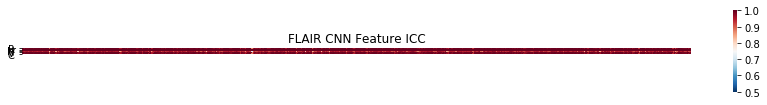

C:\Users\ncwang\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


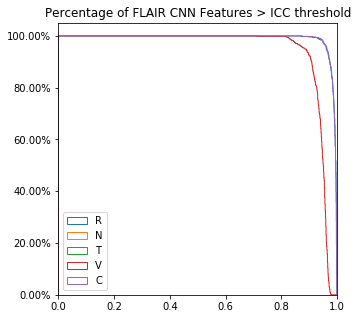

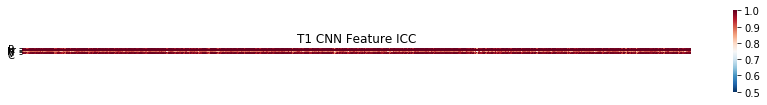

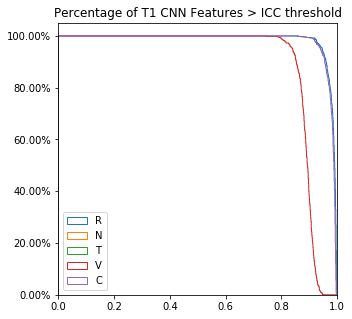

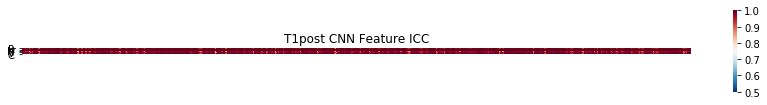

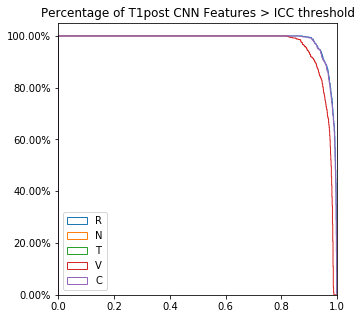

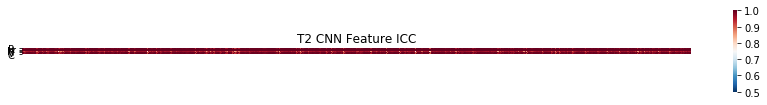

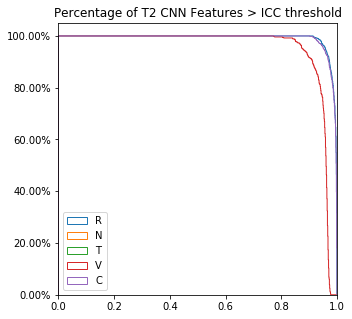

In [23]:

print(icc_vals2.shape)
print(cases)
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)
nFeat = np.int(icc_vals2.shape[0]/len(modal_list))
# modalICC = np.zeros((len(modal_list),len(feature_names_all[0])))
modalICC = np.zeros((len(cases),nFeat,len(modal_list)))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals2[idxs,:,:],axis = 2)
#     modalICC[i,:] = np.min(mICC,axis = 1)
    modalICC[:,:,i] = mICC.T
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
    f, ax = plt.subplots(figsize=(15, 1.5))
    # Draw the heatmap using seaborn
    sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
        '%s CNN Feature ICC' % (modal))
    plt.show()
    f, ax = plt.subplots(figsize=(5,5))
    plt.xlim(0,1)
    plt.title('Percentage of %s CNN Features > ICC threshold' % (modal))
    # Draw the heatmap using seaborn
    for cI in range(mICC.shape[1]):
        plt.hist(mICC[:,cI],bins = np.arange(0,1,.001),histtype = 'step',density = 'true',cumulative = -1,label = cases[cI])
#         sns.distplot(mICC[:,cI], hist_kws=dict(cumulative=-1))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.legend(loc = 'lower left')
    plt.savefig(os.path.join(outImDir,'cnn_ICC_Perc_Curve_%s.png' % (modal)))
    plt.show()
#     print(feature_names_all[i])
    

In [24]:
from rpy2.robjects import DataFrame, FloatVector, IntVector
from rpy2.robjects.packages import importr
from math import isclose

ids = np.load(os.path.join(splitdir,'label_id.npy'))
icc_vals3 = np.zeros((samples.shape[1],samples.shape[2],10))
# fold_num = 0
dataset = 'train'
for fold_num in range(10):
    icc_vals_fold = np.zeros((samples.shape[1],samples.shape[2]))
    fold_dir = os.path.join(splitdir,'fold_' +str(fold_num))
    setIdxs = np.load(os.path.join(fold_dir,dataset + '_idxs.npy')) # e.g. train, test, val

    tr_id = np.empty(len(setIdxs))

    for s_o in range(len(setIdxs)):
        s_i = setIdxs[s_o]
        tr_id[s_o]     = ids[s_i]

    tr_samples = samples[setIdxs,:,:,:]
    for prtI in range(len(cases)):
        case = cases[prtI]
        tau_vec = case_tau[case]
        if case == 'V':
            idxs = np.argwhere((np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0) & (tau_vec >=-.1) & (tau_vec <=.1))
        else:
            idxs = np.argwhere(np.count_nonzero(tr_samples[:,:,prtI,:],axis=(0,1)) > 0)
        groups = np.matlib.repmat(list(range(len(tr_id))), len(idxs),1).T.ravel()
        for ftN in range(samples.shape[1]):
            if (ftN % 100) == 0: 
                print('%d %d %d - ' % (fold_num, prtI,ftN), datetime.datetime.now().time())
            values = tr_samples[:,ftN,prtI,idxs].ravel()
            r_icc = importr("ICC")
            df = DataFrame({"groups": IntVector(groups),
                            "values": FloatVector(values)})
            icc_res = r_icc.ICCbare("groups", "values", data=df)
            icc_vals_fold[ftN,prtI] = icc_res[0] # icc_vals now holds the icc value
    icc_vals3[:,:,fold_num] = icc_vals_fold
    minICC3 = np.nanmin(icc_vals_fold,axis = 1)
    minICC3[np.isnan(minICC3)] = 0
    np.save(os.path.join(fold_dir,'cnn_feature_min_icc3.npy'),minICC3)
# check whether icc value equals reference value
# print(isclose(icc_val, 0.728, abs_tol=0.001))

0 0 0 -  17:40:38.753782
0 0 100 -  17:40:40.058244
0 0 200 -  17:40:41.223368
0 0 300 -  17:40:42.379435
0 0 400 -  17:40:43.501415
0 0 500 -  17:40:44.647453
0 0 600 -  17:40:45.792489
0 0 700 -  17:40:46.941538
0 0 800 -  17:40:48.430456
0 0 900 -  17:40:49.668769
0 0 1000 -  17:40:50.729588
0 0 1100 -  17:40:51.817463
0 0 1200 -  17:40:52.943458
0 0 1300 -  17:40:53.986226
0 0 1400 -  17:40:55.031998
0 0 1500 -  17:40:56.090602
0 0 1600 -  17:40:57.192499
0 0 1700 -  17:40:58.396301
0 0 1800 -  17:40:59.914900
0 0 1900 -  17:41:01.205252
0 0 2000 -  17:41:02.323725
0 1 0 -  17:41:02.937854
0 1 100 -  17:41:04.150103
0 1 200 -  17:41:05.303570
0 1 300 -  17:41:06.484728
0 1 400 -  17:41:07.635908
0 1 500 -  17:41:08.861729
0 1 600 -  17:41:10.014787
0 1 700 -  17:41:11.191911
0 1 800 -  17:41:12.346006
0 1 900 -  17:41:13.539138
0 1 1000 -  17:41:14.672172
0 1 1100 -  17:41:15.844254
0 1 1200 -  17:41:17.033444
0 1 1300 -  17:41:18.242987
0 1 1400 -  17:41:19.398992
0 1 1500 -  17:4

2 4 500 -  17:45:54.698513
2 4 600 -  17:45:55.988923
2 4 700 -  17:45:57.298438
2 4 800 -  17:45:58.619952
2 4 900 -  17:45:59.982565
2 4 1000 -  17:46:01.262976
2 4 1100 -  17:46:02.574437
2 4 1200 -  17:46:03.875931
2 4 1300 -  17:46:05.188409
2 4 1400 -  17:46:06.537002
2 4 1500 -  17:46:07.821411
2 4 1600 -  17:46:09.117837
2 4 1700 -  17:46:10.428345
2 4 1800 -  17:46:11.798967
2 4 1900 -  17:46:13.073414
2 4 2000 -  17:46:14.367883
3 0 0 -  17:46:15.660405
3 0 100 -  17:46:16.958887
3 0 200 -  17:46:18.322518
3 0 300 -  17:46:19.589857
3 0 400 -  17:46:20.866283
3 0 500 -  17:46:22.164731
3 0 600 -  17:46:23.463177
3 0 700 -  17:46:24.818774
3 0 800 -  17:46:26.165320
3 0 900 -  17:46:27.499887
3 0 1000 -  17:46:28.811372
3 0 1100 -  17:46:30.203064
3 0 1200 -  17:46:31.506519
3 0 1300 -  17:46:32.876122
3 0 1400 -  17:46:34.235761
3 0 1500 -  17:46:35.710671
3 0 1600 -  17:46:37.108384
3 0 1700 -  17:46:38.547169
3 0 1800 -  17:46:39.983980
3 0 1900 -  17:46:41.486996
3 0 2000 

5 3 1000 -  17:51:46.178252
5 3 1100 -  17:51:47.042514
5 3 1200 -  17:51:47.898786
5 3 1300 -  17:51:48.702719
5 3 1400 -  17:51:49.500812
5 3 1500 -  17:51:50.737082
5 3 1600 -  17:51:51.881739
5 3 1700 -  17:51:52.731095
5 3 1800 -  17:51:53.554824
5 3 1900 -  17:51:54.331014
5 3 2000 -  17:51:55.116799
5 4 0 -  17:51:55.579645
5 4 100 -  17:51:56.717088
5 4 200 -  17:51:57.875297
5 4 300 -  17:51:59.194407
5 4 400 -  17:52:00.404619
5 4 500 -  17:52:01.548682
5 4 600 -  17:52:02.832058
5 4 700 -  17:52:04.047282
5 4 800 -  17:52:05.196122
5 4 900 -  17:52:06.314066
5 4 1000 -  17:52:07.462382
5 4 1100 -  17:52:08.760861
5 4 1200 -  17:52:09.929924
5 4 1300 -  17:52:11.137158
5 4 1400 -  17:52:12.272136
5 4 1500 -  17:52:13.413165
5 4 1600 -  17:52:14.900108
5 4 1700 -  17:52:16.077231
5 4 1800 -  17:52:17.260404
5 4 1900 -  17:52:18.439387
5 4 2000 -  17:52:19.636536
6 0 0 -  17:52:20.820635
6 0 100 -  17:52:22.005811
6 0 200 -  17:52:23.198972
6 0 300 -  17:52:24.423225
6 0 400 - 

8 2 1500 -  17:57:20.742704
8 2 1600 -  17:57:21.552885
8 2 1700 -  17:57:22.364028
8 2 1800 -  17:57:23.176188
8 2 1900 -  17:57:24.061534
8 2 2000 -  17:57:24.859626
8 3 0 -  17:57:25.347979
8 3 100 -  17:57:26.167182
8 3 200 -  17:57:26.996377
8 3 300 -  17:57:27.822579
8 3 400 -  17:57:28.643751
8 3 500 -  17:57:29.477964
8 3 600 -  17:57:30.303153
8 3 700 -  17:57:31.134352
8 3 800 -  17:57:31.959520
8 3 900 -  17:57:32.794769
8 3 1000 -  17:57:33.626943
8 3 1100 -  17:57:34.484384
8 3 1200 -  17:57:35.374218
8 3 1300 -  17:57:36.189409
8 3 1400 -  17:57:37.018615
8 3 1500 -  17:57:37.843791
8 3 1600 -  17:57:38.871497
8 3 1700 -  17:57:39.912259
8 3 1800 -  17:57:41.467384
8 3 1900 -  17:57:42.566298
8 3 2000 -  17:57:43.633130
8 4 0 -  17:57:44.244752
8 4 100 -  17:57:45.647474
8 4 200 -  17:57:47.741027
8 4 300 -  17:57:49.141766
8 4 400 -  17:57:50.413146
8 4 500 -  17:57:51.680479
8 4 600 -  17:57:52.956894
8 4 700 -  17:57:54.274389
8 4 800 -  17:57:55.529720
8 4 900 -  17:5

In [34]:
print(np.count_nonzero(minICC2 < .75))
print(np.count_nonzero(minICC2 < .75)/len(minICC2))
print(np.count_nonzero(minICC2 < .90))
print(np.count_nonzero(minICC2 < .90)/len(minICC2))
print(np.mean(icc_vals2[:,:,0], axis=0))
print(np.mean(icc_vals3, axis=(0,2)))
print(np.count_nonzero(icc_vals3[:,1,:] < .90))
print(np.count_nonzero(icc_vals3[:,1,:] < .90))

1
0.00048828125
413
0.20166015625
[0.98616036 0.99999775 1.         0.93954413 0.9847924 ]
[0.98691561 0.99999803 1.         0.98915871 0.98540368]
0


In [57]:
minCT = np.zeros((10,1))
for i in range(10):
    minICC2 = np.nanmin(icc_vals2[:,:,i],axis = 1)
    minCT[i] = np.count_nonzero(minICC2<=.75)
#     print(minCT[i])
print(np.mean(minCT))
print(np.count_nonzero(np.logical_not(np.isnan(minICC2))))

print(np.mean(minCT)/np.count_nonzero(np.logical_not(np.isnan(minICC2))))
print(np.count_nonzero((minICC2<=.75) & np.logical_not(np.isnan(minICC2))))

3.1
2048
0.001513671875
1


(2048, 5, 10)
['R', 'N', 'T', 'V', 'C']


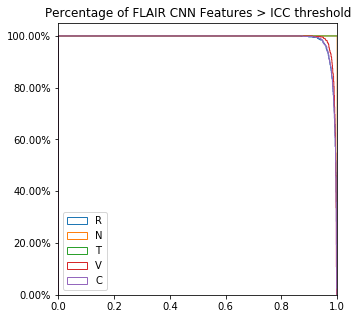

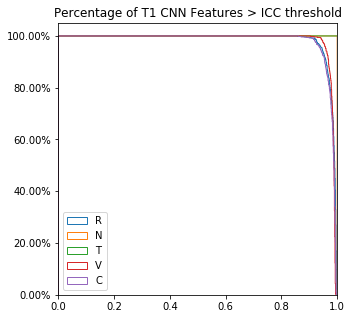

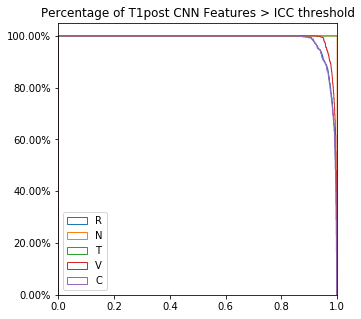

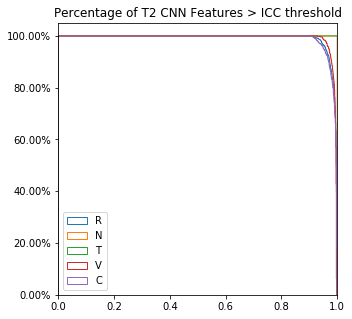

In [36]:

print(icc_vals3.shape)
print(cases)
outImDir = os.path.join(basedir,'images','ICC')
if not(os.path.exists(outImDir)):
    os.makedirs(outImDir)
nFeat = np.int(icc_vals3.shape[0]/len(modal_list))
# modalICC = np.zeros((len(modal_list),len(feature_names_all[0])))
modalICC = np.zeros((len(cases),nFeat,len(modal_list)))
for i in range(len(modal_list)):
    modal = modal_list[i]
    idxs = np.arange(nFeat) + (i*nFeat)
    mICC = np.mean(icc_vals3[idxs,:,:],axis = 2)
#     modalICC[i,:] = np.min(mICC,axis = 1)
    modalICC[:,:,i] = mICC.T
    mICC = mICC[np.logical_not(np.isnan(mICC[:,1])),:]
    ICCDF = pd.DataFrame(data=mICC, columns=cases)
#     f, ax = plt.subplots(figsize=(15, 1.5))
#     # Draw the heatmap using seaborn
#     sns.heatmap(ICCDF.T, square=True,cmap = 'RdBu_r', xticklabels = False, vmin = .5, vmax = 1).set_title(
#         '%s CNN Feature ICC' % (modal))
#     plt.show()
    f, ax = plt.subplots(figsize=(5,5))
    plt.xlim(0,1)
    plt.title('Percentage of %s CNN Features > ICC threshold' % (modal))
    # Draw the heatmap using seaborn
    for cI in range(mICC.shape[1]):
        plt.hist(mICC[:,cI],bins = np.arange(0,1.01,.001),histtype = 'step',density = 'true',cumulative = -1,label = cases[cI])
#         sns.distplot(mICC[:,cI], hist_kws=dict(cumulative=-1))
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    plt.legend(loc = 'lower left')
    plt.savefig(os.path.join(outImDir,'cnn_ICC_Perc_Curve_%s_icc3.png' % (modal)))
    plt.show()
#     print(feature_names_all[i])
    

In [31]:
minCT = np.zeros((10,1))
minCT_9 = np.zeros((10,1))
for i in range(10):
    minICC3 = np.nanmin(icc_vals3[:,:,i],axis = 1)
    minCT[i] = np.count_nonzero(minICC3<=.75)
    minCT_9[i] = np.count_nonzero(minICC3<=.9)
#     print(minCT[i])
print(np.mean(minCT))
print(np.count_nonzero(np.logical_not(np.isnan(minICC3))))

print(np.mean(minCT)/np.count_nonzero(np.logical_not(np.isnan(minICC3))))
print(np.count_nonzero((minICC3<=.75) & np.logical_not(np.isnan(minICC3))))
print(np.mean(minCT_9)/np.count_nonzero(np.logical_not(np.isnan(minICC3))))
print(np.count_nonzero((minICC3<=.9) & np.logical_not(np.isnan(minICC3))))

0.0
2048
0.0
0
0.007080078125
9
